#### Passo a passo do código


1) Em primeiro lugar, vamos importar as bibliotecas que iremos utilizar.

In [41]:
from scipy.integrate import odeint
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

1.1) Vamos definir uma função para facilitar os cálculos das constantes:

In [42]:
def calcula_k(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar):
    k2 = (hs * As) / (ml * cl)
    k3 = (kr * Ar) / (ml * cl * dr)
    k1 = k2 + k3
    k1_linha = (kr * Ar) / (mr * cr * dr)
    k2_linha = 1 / ((1 / k1_linha) + ((mr * cr) / (hp * Ap)))
    k3_linha = k1_linha + k2_linha
    ks = [k1, k2, k3]
    k_linhas = [k1_linha, k2_linha, k3_linha]
    return ks, k_linhas

2)Em segundo lugar, vamos precisar ter valores para utilizar nas funções e equações diferenciais.

In [43]:
R = 3.6 * 0.01 # em metros (x cm de raio da xicara * fator de conversão)
h = 7 * 0.01 # em metros (x cm de altura da xicara * fator de conversão)
ml = 200 # g (de café) 
cl = 4.186 # J / g . °C - fixo
mr = 300 # g (massa da xícara ou recipiente)
cr = 0.67 # 0.67 J / g . °C (Calor especifico do vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
dr = 0.2 * 0.01 # em metros (x centímetros de raio da xícara)
hs = 26 # W / m**2 . K (média, valor varia de 10 a 100)
As = pi * R * R # (area da superfície convectiva é a area da boca da xícara)
hp = 26 # W / m**2 . K (média, valor varia de 10 a 100)
Ap = 2 * pi * R * h
kr = 0.75 # W / m . K (média para o vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
Ar = Ap

2.1) Vamos calcular os k's e definir nossa função modelo que calcula as derivadas

In [44]:
ks, k_linhas = calcula_k(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar)
k1 = ks[0]
k2 = ks[1]
k3 = ks[2]
k1_linha = k_linhas[0]
k2_linha = k_linhas[1]
k3_linha = k_linhas[2]


def modelo(TLTR, t, k1, k2, k3, k1_linha, k2_linha, k3_linha, Ta):
    TL = TLTR[0]
    TR = TLTR[1]
    dTLdt = (-1) * k1 * TL + k2 * Ta + k3 * TR
    dTRdt = k1_linha * TL + k2_linha * Ta - k3_linha * TR
    derivadas = [dTLdt, dTRdt]
    return derivadas

2.2) Vamos agora definir nossas condições iniciais e construir uma lista temporal:

In [45]:
# Tliquido inicial é 82°C
TL0 = 82

# Trecipiente inicial é 82°C
TR0 = 34

# Temperatura ambiente
Ta = 30

# Lista de condições iniciais
TLTR = [TL0, TR0]

# Lista temporal
dt = 1
t_final = 100000
lista_t = np.arange(0, t_final, dt)

3) Execução da função ODEINT para a resolução das equações diferenciais:

In [46]:
y = odeint(modelo, TLTR, lista_t, args=(k1, k2, k3, k1_linha, k2_linha, k3_linha, Ta))

TL_modelo = y[:,0]
TR_modelo = y[:,1]

4) Encontre o tempo de resfriamento do café, OBS.: O gráfico tem assintota em Ta, portanto ele levará um tempo infinito até atingir Ta de fato (matematicamente). Leve em consideração que o líquido resfriou quando ele atingir uma temperatura de Ta + dT. Onde dT será um valor razoavelmente pequeno. Adote dT = 1.5 °C:

In [47]:
# Encontra tempo de resfriamento
dT = 5
for i in range(len(TL_modelo)):
    if TL_modelo[i] < Ta + dT:
        tempo_de_resfriamento = lista_t[i]
        break

5) Dê o um print mostrando quanto foi o tempo necessário para o café resfriar:

In [48]:
print(f"O café atinge a temperatura de {Ta + dT}°C em {tempo_de_resfriamento / 60:.2f} minutos")

O café atinge a temperatura de 35°C em 78.42 minutos


6) Por fim, plote o gráfico das temperaturas do café e do recipiente em função do tempo:

10000


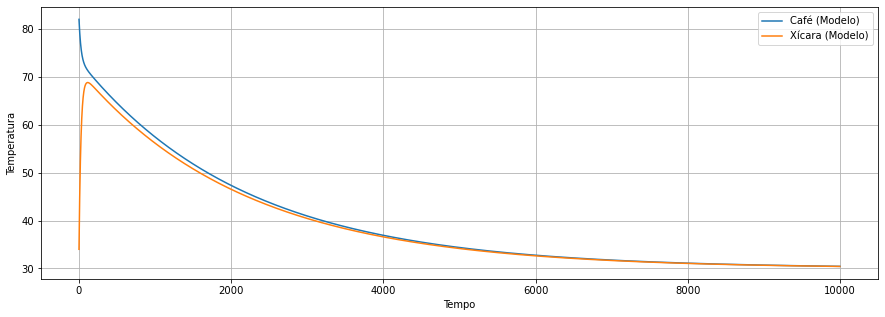

In [49]:
# i_fim será o ultimo indice plotado pelo gráfico
# i_fim será determinado pelo t_limite (em segundos)
t_limite = 10000
i_fim = int(t_limite)
print(i_fim)
plt.figure(figsize=(15, 5))
#print(lista_t)
plt.plot(lista_t[0:i_fim], TL_modelo[0:i_fim], label='Café (Modelo)')
plt.plot(lista_t[0:i_fim], TR_modelo[0:i_fim], label='Xícara (Modelo)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

### Validação do modelo

i) Agora utilizaremos um experimento feito em com a coleta de dados de temperatura de uma xícara de café resfriando.
i.1) Para a realização do experimento, foram necessários:

1) 2 sensores de temperatura NTC10K (A prova dágua)
2) 1 Arduino uno
3) 1 protoboard
4) 2 resistores de 10kohms
5) Jumpers
6) Xícara a temperatura ambiente
7) Café a 80°C

ii) Para a implementação do código, fizemos um código que aproveitasse ao máximo o clock do Arduino. Como nosso \Delta t é de 1 seg, temos margem para utilizar o arduino para fazer diversos cálculos dentro desse intervalo de tempo. Dessa forma, implementamos uma função de cálculo de médias aritméticas para tornar o valor final da temperatura o mais preciso possível e melhorarmos o ruido associado ao termistor utilizado (NTC10K).

iii) Exibimos todos os dados dentro de um intervalo de 16mil segundos no monitor serial do Arduino, salvamos em um arquivo .csv e utilizaremos o Pandas para abrir esses dados em forma de tabelas e em seguida plotar os gráficos.

1) Vamos ler esses arquivos:

In [50]:
# Lê arquivo csv
tabela = pd.read_csv('data2.csv')
#display(tabela)
Tliquido_com_medias = list(tabela['Tliquido medio'])
Tliquido_sem_medias = list(tabela['Tliquido'])
Trecipiente_com_medias = list(tabela['Trecipiente medio'])
Trecipiente_sem_medias = list(tabela['Trecipiente'])
lista_t_exp = list(tabela['Tempo'])

2) Determine o tempo de resfriamento do experimento:

In [51]:
# Determina tempo de resfriamento
dT = 5
for i in range(len(Tliquido_com_medias)):
    if Tliquido_com_medias[i] < Ta + dT:
        tempo_de_resfriamento2 = lista_t_exp[i]
        break

3) Exiba o tempo de resfriamento com um print:

In [52]:
print(f"O café atinge a temperatura de {Ta + dT}°C em {tempo_de_resfriamento2 / 60:.2f} minutos")

O café atinge a temperatura de 35°C em 83.15 minutos


3.1) Utilize o t_limite para achar o indice i_fim

In [53]:
for i in range(len(lista_t_exp)):
    if lista_t_exp[i] > t_limite:
        i_fim_exp = i
        break
print(i_fim_exp)

9240


4) Plote os dois gráficos experimentais:

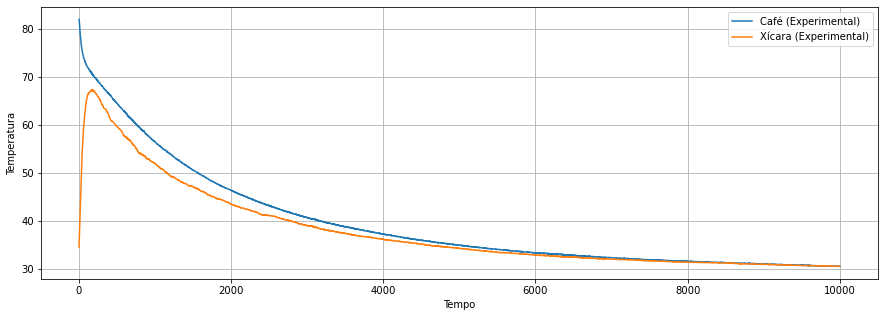

In [54]:
plt.figure(figsize=(15, 5))
plt.plot(lista_t_exp[0:i_fim_exp], Tliquido_com_medias[0:i_fim_exp], label='Café (Experimental)')
plt.plot(lista_t_exp[0:i_fim_exp], Trecipiente_com_medias[0:i_fim_exp], label='Xícara (Experimental)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

## Validação
#### 1) Plote o gráfico do modelo com o gráfico do experimento da temperatura do café

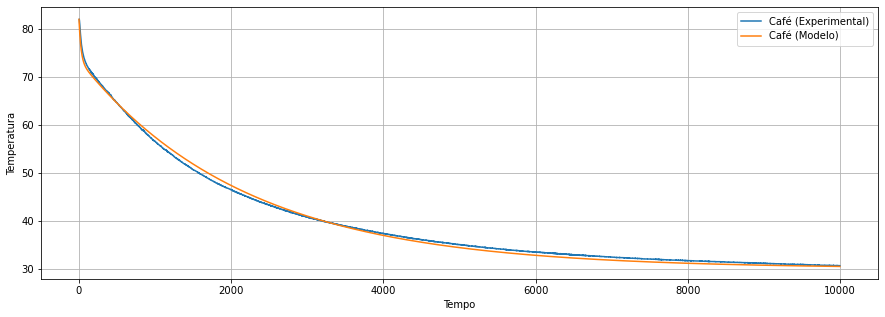

In [55]:
i_fim = 10000
plt.figure(figsize=(15, 5))
plt.plot(lista_t_exp[0:i_fim_exp], Tliquido_com_medias[0:i_fim_exp], label='Café (Experimental)')
plt.plot(lista_t[0:i_fim], TL_modelo[0:i_fim], label='Café (Modelo)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

2) Agora use um print para mostrar os tempos de resfriamento dos dois:

In [56]:
print(f"Modelo: O café atinge a temperatura de {Ta + dT}°C em {tempo_de_resfriamento / 60:.2f} minutos")
print(f"Experimento: O café atinge a temperatura de {Ta + dT}°C em {tempo_de_resfriamento2 / 60:.2f} minutos")

Modelo: O café atinge a temperatura de 35°C em 78.42 minutos
Experimento: O café atinge a temperatura de 35°C em 83.15 minutos


#### 1) Plote o gráfico do modelo com o gráfico do experimento da temperatura da xícara

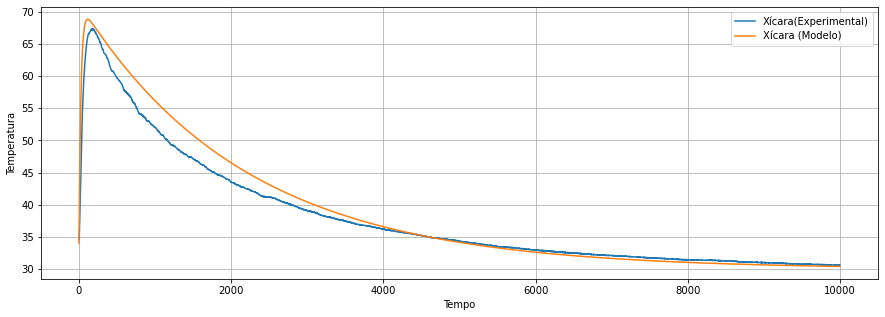

In [57]:
i_fim = 10000
plt.figure(figsize=(15, 5))
plt.plot(lista_t_exp[0:i_fim_exp], Trecipiente_com_medias[0:i_fim_exp], label='Xícara(Experimental)')
plt.plot(lista_t[0:i_fim], TR_modelo[0:i_fim], label='Xícara (Modelo)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

# Segunda Iteração: Considerando a radiação do corpo negro

Agora vamos considerar mais um fluxo de calor saindo do estoque do café devido à perda de calor pela radiação do corpo negro.
Considera a equação de Boltzman.

In [58]:
R = 3.5 * 0.01 # em metros (x cm de raio da xicara * fator de conversão)
h = 7 * 0.01 # em metros (x cm de altura da xicara * fator de conversão)
ml = 200 # g (de café) 
cl = 4.186 # J / g . °C - fixo
mr = 320 # g (massa da xícara ou recipiente)
cr = 0.67 # 0.67 J / g . °C (Calor especifico do vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
dr = 0.25 * 0.01 # em metros (x centímetros de raio da xícara)
hs = 24.5 # W / m**2 . K (média, valor varia de 10 a 100)
As = pi * R * R # (area da superfície convectiva é a area da boca da xícara)
hp = 24.5 # W / m**2 . K (média, valor varia de 10 a 100)
Ap = 2 * pi * R * h
kr = 0.8 # W / m . K (média para o vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
Ar = Ap

In [59]:
ks, k_linhas = calcula_k(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar)
k1 = ks[0]
k2 = ks[1]
k3 = ks[2]
k1_linha = k_linhas[0]
k2_linha = k_linhas[1]
k3_linha = k_linhas[2]


def modelo(TLTR, t, k1, k2, k3, k1_linha, k2_linha, k3_linha, Ta):
    TL = TLTR[0]
    TR = TLTR[1]
    e = 0.95
    A = As
    sigma = 5.6703e-8
    TL_4 = TL * TL * TL * TL
    qrad = e * sigma * A * TL_4
    dTLdt = (-1) * k1 * TL + k2 * Ta + k3 * TR - qrad
    dTRdt = k1_linha * TL + k2_linha * Ta - k3_linha * TR
    derivadas = [dTLdt, dTRdt]
    return derivadas

In [60]:
# Tliquido inicial é 82°C
TL0 = 82

# Trecipiente inicial é 82°C
TR0 = 34

# Temperatura ambiente
Ta = 30

# Lista de condições iniciais
TLTR = [TL0, TR0]

In [61]:
y = odeint(modelo, TLTR, lista_t, args=(k1, k2, k3, k1_linha, k2_linha, k3_linha, Ta))

TL_modelo = y[:,0]
TR_modelo = y[:,1]

In [62]:
# Encontra tempo de resfriamento
dT = 5
for i in range(len(TL_modelo)):
    if TL_modelo[i] < Ta + dT:
        tempo_de_resfriamento = lista_t[i]
        break

In [63]:
print(f"O café atinge a temperatura de {Ta + dT}°C em {tempo_de_resfriamento / 60:.2f} minutos")

O café atinge a temperatura de 35°C em 76.98 minutos


10000


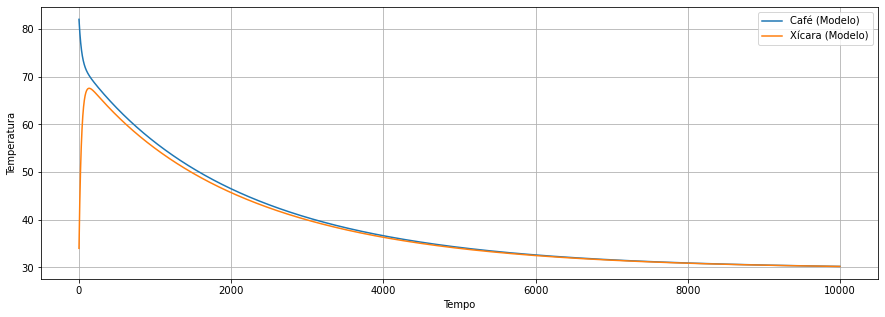

In [64]:
# i_fim será o ultimo indice plotado pelo gráfico
# i_fim será determinado pelo t_limite (em segundos)
t_limite = 10000
i_fim = int(t_limite)
print(i_fim)
plt.figure(figsize=(15, 5))
#print(lista_t)
plt.plot(lista_t[0:i_fim], TL_modelo[0:i_fim], label='Café (Modelo)')
plt.plot(lista_t[0:i_fim], TR_modelo[0:i_fim], label='Xícara (Modelo)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

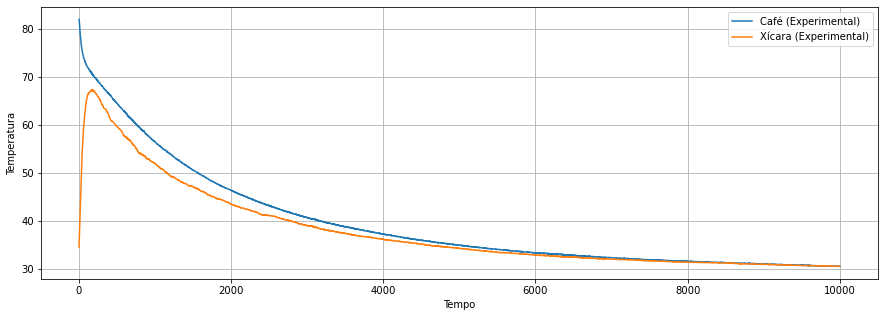

In [65]:
plt.figure(figsize=(15, 5))
plt.plot(lista_t_exp[0:i_fim_exp], Tliquido_com_medias[0:i_fim_exp], label='Café (Experimental)')
plt.plot(lista_t_exp[0:i_fim_exp], Trecipiente_com_medias[0:i_fim_exp], label='Xícara (Experimental)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

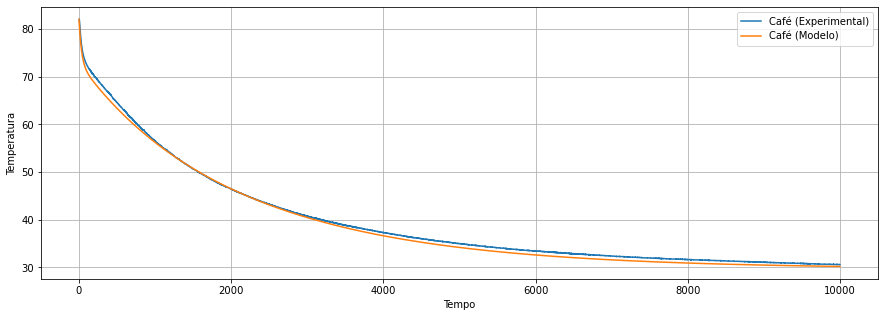

In [66]:
i_fim = 10000
plt.figure(figsize=(15, 5))
plt.plot(lista_t_exp[0:i_fim_exp], Tliquido_com_medias[0:i_fim_exp], label='Café (Experimental)')
plt.plot(lista_t[0:i_fim], TL_modelo[0:i_fim], label='Café (Modelo)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

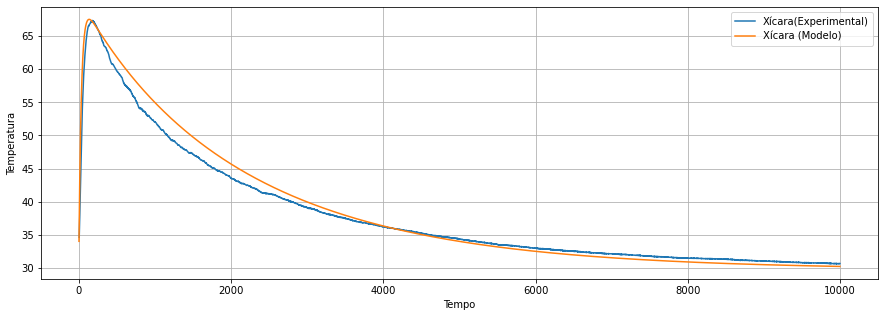

In [67]:
i_fim = 10000
plt.figure(figsize=(15, 5))
plt.plot(lista_t_exp[0:i_fim_exp], Trecipiente_com_medias[0:i_fim_exp], label='Xícara(Experimental)')
plt.plot(lista_t[0:i_fim], TR_modelo[0:i_fim], label='Xícara (Modelo)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

In [68]:
print(f"Modelo: O café atinge a temperatura de {Ta + dT}°C em {tempo_de_resfriamento / 60:.2f} minutos")
print(f"Experimento: O café atinge a temperatura de {Ta + dT}°C em {tempo_de_resfriamento2 / 60:.2f} minutos")

Modelo: O café atinge a temperatura de 35°C em 76.98 minutos
Experimento: O café atinge a temperatura de 35°C em 83.15 minutos


#### Gráfico geral
Nesse tópico, acompanhe todos os gráficos juntos:

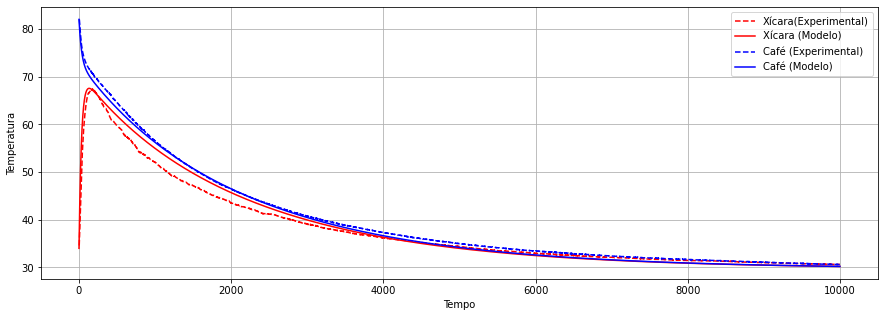

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(lista_t_exp[0:i_fim_exp], Trecipiente_com_medias[0:i_fim_exp],'r--', label='Xícara(Experimental)')
plt.plot(lista_t[0:i_fim], TR_modelo[0:i_fim],'r', label='Xícara (Modelo)')
plt.plot(lista_t_exp[0:i_fim_exp], Tliquido_com_medias[0:i_fim_exp],'b--', label='Café (Experimental)')
plt.plot(lista_t[0:i_fim], TL_modelo[0:i_fim],'b', label='Café (Modelo)')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.grid(True)
plt.legend()
plt.show()

### Tirando conclusões do modelo
Com o modelo validado, podemos tirar conclusões a respeito da modificação de alguns parâmetros. Para o nosso experimento utilizamos uma xícara de vidro, vamos utilizar outros parâmetros de outros materiais e fazer um gráfico de tempo de resfriamento por calor sensível.

In [70]:
# Alguns calores específicos e condutividades térmicas
'''
Legenda:
-- ceramicas
0 - alumina (Al2O3) (cr = 0.775; kr = 39)
1 - Magnésia (MgO) (cr = 0.94; kr = 37.7)
2 - Espinélio (MgAl2O4) (cr = 0.79; kr = 15)
3 - Sílica fundida (SiO2) (cr = 0.74; kr = 1.4)
4 - Vidro de cal de soda (cr = 0.84; kr = 1.7)
5 - Vidro borossolicato (Pirex) (cr = 0.85; kr = 1.4)
6 - Vidro comum (cr = 0.669; kr = 0.8)
7 - Porcelana (cr = 1.07; kr = 0.8 <--- Precisa atualizar esse valor)
-- polimeros
8 - Polietileno (alta densidade) (cr = 0.669; kr = 0.8)
9 - Polipropileno (cr = 0.669; kr = 0.8)
10 - Poliestireno (cr = 0.669; kr = 0.8)
11 - Politetrafluoroetileno (Teflon) (cr = 0.669; kr = 0.8)
12 - Fenol-formaldeído, fenólico (Baquelite) (cr = 0.669; kr = 0.8)
13 - Nylon 6,6 (cr = 0.669; kr = 0.8)
 
'''
crs = [0.775, 0.94, 0.79, 0.74, 0.84, 0.85, 0.669, 1.07, 1.85, 1.925, 1.170, 1.05, 1.675, 1.67]
krs = [39, 37.7, 15, 1.4, 1.7, 1.4, 0.8, 0.8, 0.48, 0.12, 0.13, 0.25, 0.15, 0.24]

#### Função de tempo de resfriamento
Nessa etapa, vamos criar uma função que só irá calcular o tempo de resfriamento:

In [71]:
def calcula_tempo_de_resfriamento(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar):
    
    ks, k_linhas = calcula_k(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar)
    k1 = ks[0]
    k2 = ks[1]
    k3 = ks[2]
    k1_linha = k_linhas[0]
    k2_linha = k_linhas[1]
    k3_linha = k_linhas[2]

    # Tliquido inicial é 82°C
    TL0 = 82

    # Trecipiente inicial é 82°C
    TR0 = 34

    # Temperatura ambiente
    Ta = 30

    # Lista de condições iniciais
    TLTR = [TL0, TR0]

    # Lista temporal
    dt = 1
    t_final = 100000
    lista_t = np.arange(0, t_final, dt)

    y = odeint(modelo, TLTR, lista_t, args=(k1, k2, k3, k1_linha, k2_linha, k3_linha, Ta))

    TL_modelo = y[:,0]
    TR_modelo = y[:,1]

    # Encontra tempo de resfriamento
    tempo_de_resfriamento = 100000 # Caso o tempo seja infinito
    dT = 5
    for i in range(len(TL_modelo)):
        if TL_modelo[i] < Ta + dT:
            tempo_de_resfriamento = lista_t[i]
            break
    tempo_de_resfriamento = tempo_de_resfriamento / 60 # em minutos
    return tempo_de_resfriamento

print(calcula_tempo_de_resfriamento(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar))

76.98333333333333


#### Lista de valores de tempo de resfriamento:
Aqui vamos criar uma lista de valores de tempo de resfriamento em função dos parâmetros crs e krs:

In [72]:
lista_t_resfriamento = []
for i in range(len(crs)):
    cr = crs[i]
    kr = krs[i]
    tempo = calcula_tempo_de_resfriamento(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar)
    lista_t_resfriamento.append(tempo)
print(lista_t_resfriamento)

[72.3, 74.4, 72.7, 75.3, 75.96666666666667, 76.71666666666667, 76.96666666666667, 82.03333333333333, 94.7, 118.98333333333333, 108.6, 93.8, 110.88333333333334, 101.6]


#### Vamos gerar um gráfico 3D
1) Eixo x: Calor sensível da xícara 

2) Eixo y: Condutividade térmica da xícara

3) Eixo z: Tempo de resfriamento do café

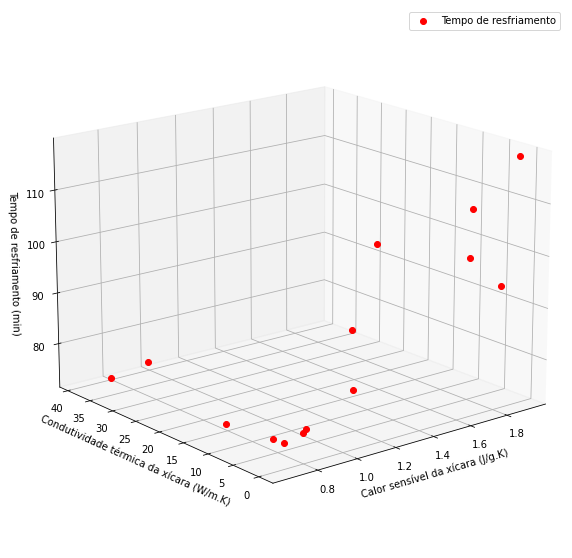

In [73]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

'''
Legenda:
-- ceramicas
0 - alumina (Al2O3) (cr = 0.775; kr = 39)
1 - Magnésia (MgO) (cr = 0.94; kr = 37.7)
2 - Espinélio (MgAl2O4) (cr = 0.79; kr = 15)
3 - Sílica fundida (SiO2) (cr = 0.74; kr = 1.4)
4 - Vidro de cal de soda (cr = 0.84; kr = 1.7)
5 - Vidro borossolicato (Pirex) (cr = 0.85; kr = 1.4)
6 - Vidro comum (cr = 0.669; kr = 0.8)
7 - Porcelana (cr = 1.07; kr = 0.8 <--- Precisa atualizar esse valor)
-- polimeros
8 - Polietileno (alta densidade) (cr = 0.669; kr = 0.8)
9 - Polipropileno (cr = 0.669; kr = 0.8)
10 - Poliestireno (cr = 0.669; kr = 0.8)
11 - Politetrafluoroetileno (Teflon) (cr = 0.669; kr = 0.8)
12 - Fenol-formaldeído, fenólico (Baquelite) (cr = 0.669; kr = 0.8)
13 - Nylon 6,6 (cr = 0.669; kr = 0.8)
 
'''


crs = [0.775, 0.94, 0.79, 0.74, 0.84, 0.85, 0.669, 1.07, 1.85, 1.925, 1.170, 1.05, 1.675, 1.67]
krs = [39, 37.7, 15, 1.4, 1.7, 1.4, 0.8, 0.8, 0.48, 0.12, 0.13, 0.25, 0.15, 0.24]
lista_t_resfriamento = [72.3, 74.4, 72.7, 75.3, 75.96666666666667, 76.71666666666667, 76.96666666666667, 82.03333333333333, 94.7, 118.98333333333333, 108.6, 93.8, 110.88333333333334, 101.6]

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(111, projection='3d')
ax.plot(crs, krs, lista_t_resfriamento, 'ro', label='Tempo de resfriamento')

ax.set_xlabel('Calor sensível da xícara (J/g.K)')
ax.set_ylabel('Condutividade térmica da xícara (W/m.K) ')
ax.set_zlabel('Tempo de resfriamento (min)')

plt.legend()
ax.view_init(17, -129)
plt.show()

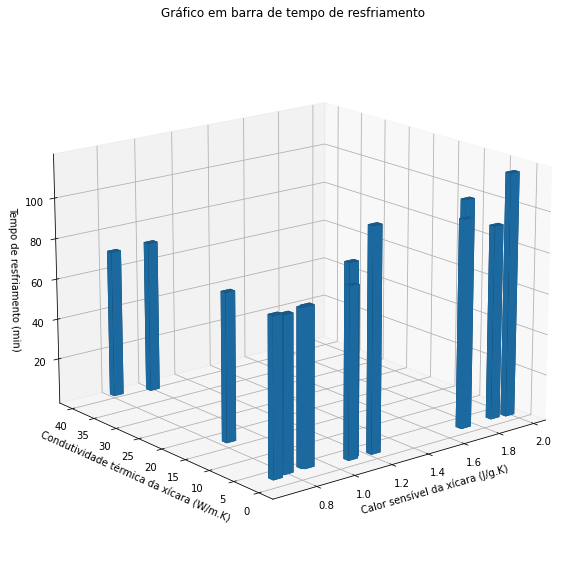

In [74]:
'''from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style'''

#style.use('ggplot')

fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(111, projection='3d')

x3 = crs
y3 = krs
z3 = 0.0001

dx = 0.05
dy = 1
dz = lista_t_resfriamento

ax1.bar3d(x3, y3, z3, dx, dy, dz, shade=True)

ax1.set_title('Gráfico em barra de tempo de resfriamento')

ax1.set_xlabel('Calor sensível da xícara (J/g.K)')
ax1.set_ylabel('Condutividade térmica da xícara (W/m.K) ')
ax1.set_zlabel('Tempo de resfriamento (min)')

ax1.view_init(17, -129)
plt.show()

## Nova conclusão
Tendo em vista que sabemos o melhor material possível, vamos utilizar esse material fixo e variar agora as dimensões da xícara, em busca, novamente, do maior tempo possível.

### Parêmetros que vamos fixar:
1) ml, cl, mr, cr, kr, hs, hp 
2) Volume da xícara



In [75]:
vol = pi * R * 100 * R * 100 * h * 100
print(vol)

269.3915700453249


In [76]:
# Lista de valores de R
Ri = 1 * 0.01
Rf = 5 * 0.01
dR = 0.1 * 0.01
Rs = np.arange(Ri, Rf, dR)

# Lista de valores de h
hi = 3 * 0.01
hf = 10 * 0.01
dh = 0.1 * 0.01
h_s = np.arange(hi, hf, dh)

# Melhor material
cr_best = 1.675
kr_best = 0.15
#print(hs, Rs)
lista_de_pontos = []
for i in range(len(Rs)):
    for j in range(len(h_s)):
        R = Rs[i]
        h = h_s[j]
        As = pi * R * R
        Ap = 2 * pi * R * h
        Ar = Ap
        vol = As * h * 1000000
        ml = vol * 0.75
        tempo = calcula_tempo_de_resfriamento(ml, cl, mr, cr_best, dr, hs, As, hp, Ap, kr_best, Ar)
        lista_de_pontos.append((R, h, tempo))

In [77]:
x, y, z = [], [], []
for i in range(len(lista_de_pontos)):
    x.append(lista_de_pontos[i][0])
    y.append(lista_de_pontos[i][1])
    z.append(lista_de_pontos[i][2])

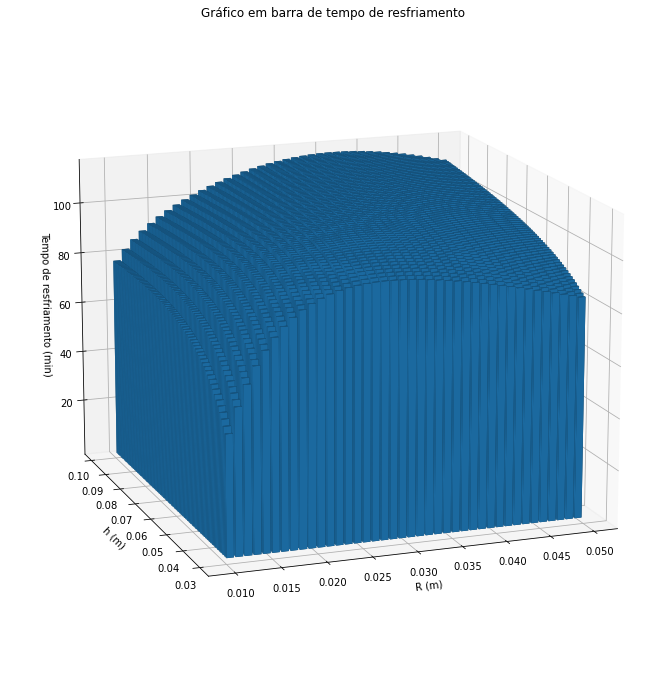

In [78]:
fig = plt.figure(figsize=(30, 12))
ax1 = fig.add_subplot(111, projection='3d')

x3 = x
y3 = y
z3 = 0.0001

dx = 0.0008
dy = 0.0005
dz = z

ax1.bar3d(x3, y3, z3, dx, dy, dz, shade=True)

ax1.set_title('Gráfico em barra de tempo de resfriamento')

ax1.set_xlabel('R (m)')
ax1.set_ylabel('h (m)')
ax1.set_zlabel('Tempo de resfriamento (min)')

ax1.view_init(15, -110)
plt.show()

# Melhorias do modelo:
### 1) Considerar a variedade de densidade dos materiais:
Aqui, por simplificação, consideramos que os valores que variaram foram os de calor sensível, condutividade térmica, raio e altura da xícara. É imprescindível que para a melhora da análise sejam considerados os valores reais de densidade dos materiais. 

### 2) Considerar a espessura da xícara:
Durante toda a análise foi considerado somente 1 valor para a espessura da xícara. Uma possível melhoria do modelo é quando variarmos os valores de raio e altura, variarmos proporcionalmente os valores de espessura.

### 3) Considerar ...

In [101]:
import plotly.graph_objects as go

fig = go.Figure(data =
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625, 20],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]],
        x=[-9, -6, -5 , -3, -1], # horizontal axis
        y=[0, 1, 4, 5, 7], # vertical axis
        colorscale='Hot',
        contours=dict(
            start=0,
            end=8,
            size=2,
    )))
fig.show()



In [171]:
# Lista de valores de R
Ri = 1 * 0.01
Rf = 7 * 0.01
dR = 0.1 * 0.01
Rs = np.arange(Ri, Rf, dR)

# Lista de valores de h
hi = 3 * 0.01
hf = 15 * 0.01
dh = 0.1 * 0.01
h_s = np.arange(hi, hf, dh)

# Melhor material
cr_best = 1.675
kr_best = 0.15
#print(hs, Rs)
lista_de_pontos = []
for i in range(len(Rs)):
    for j in range(len(h_s)):
        R = Rs[i]
        h = h_s[j]
        As = pi * R * R
        Ap = 2 * pi * R * h
        Ar = Ap
        vol = As * h * 1000000
        ml = vol * 0.75
        tempo = calcula_tempo_de_resfriamento(ml, cl, mr, cr_best, dr, hs, As, hp, Ap, kr_best, Ar)
        lista_de_pontos.append((R, h, tempo))

In [172]:
x, y, z = [], [], []
for i in range(len(lista_de_pontos)):
    x.append(lista_de_pontos[i][0])
    y.append(lista_de_pontos[i][1])
    z.append(lista_de_pontos[i][2])

In [183]:
z_new = list(z)
x_new = list(x)
y_new = list(y)


In [197]:
import plotly.graph_objects as go

layout = go.Layout(title='Tempo de resfriamento em função de R e h',
                   yaxis={'title':'h (m)'},
                   xaxis={'title': 'R (m)'})

fig = go.Figure(data =
    go.Contour(
        z=z,
        x=x_new, # horizontal axis
        y=y_new, # vertical axis
    ), layout=layout)


fig.show()


In [258]:
R = 3.5 * 0.01 # em metros (x cm de raio da xicara * fator de conversão)
h = 7 * 0.01 # em metros (x cm de altura da xicara * fator de conversão)
ml = 200 # g (de café) 
cl = 4.186 # J / g . °C - fixo
mr = 320 # g (massa da xícara ou recipiente)
cr = 0.67 # 0.67 J / g . °C (Calor especifico do vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
dr = 0.25 * 0.01 # em metros (x centímetros de raio da xícara)
hs = 24.5 # W / m**2 . K (média, valor varia de 10 a 100)
As = pi * R * R # (area da superfície convectiva é a area da boca da xícara)
hp = 24.5 # W / m**2 . K (média, valor varia de 10 a 100)
Ap = 2 * pi * R * h
kr = 0.8 # W / m . K (média para o vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
Ar = Ap

crs = [0.775, 0.94, 0.79, 0.74, 0.84, 0.85, 0.669, 1.07, 1.85, 1.925, 1.170, 1.05, 1.675, 1.67]
krs = [39, 37.7, 15, 1.4, 1.7, 1.4, 0.8, 0.8, 0.48, 0.12, 0.13, 0.25, 0.15, 0.24]

# Lista de valores de kr
kri = 0.001
krf = 1
dkr = 0.001
krs = np.arange(kri, krf, dkr)

# Lista de valores de h
cri = 0.5
crf = 6
dcr = 0.1
crs = np.arange(cri, crf, dcr)

# Fixosss
#R = 3.5 * 0.01 # em metros (x cm de raio da xicara * fator de conversão)
#h = 7 * 0.01 # em metros (x cm de altura da xicara * fator de conversão)

lista_de_pontos2 = []
for i in range(len(crs)):
    for j in range(len(krs)):
        cr = crs[i]
        kr = krs[j]
        tempo = calcula_tempo_de_resfriamento(ml, cl, mr, cr, dr, hs, As, hp, Ap, kr, Ar)
        lista_de_pontos2.append((cr, kr, tempo))

In [259]:

x2, y2, z2 = [], [], []
for i in range(len(lista_de_pontos2)):
    x2.append(lista_de_pontos2[i][0])
    y2.append(lista_de_pontos2[i][1])
    z2.append(lista_de_pontos2[i][2])

In [260]:
z_new2 = list(z2)
x_new2 = list(x2)
y_new2 = list(y2)

In [261]:
layout = go.Layout(title='Tempo de resfriamento (min)',
                   yaxis={'title':'Condutividade térmica da xícara (W/m.K) '},
                   xaxis={'title':'Calor sensível da xícara (J/g.K) '})
fig2 = go.Figure(data = go.Contour(z=z2, x=x_new2, y=y_new2), layout=layout)
fig2.show()

In [255]:
R = 3.5 * 0.01 # em metros (x cm de raio da xicara * fator de conversão)
h = 7 * 0.01 # em metros (x cm de altura da xicara * fator de conversão)
ml = 200 # g (de café) 
cl = 4.186 # J / g . °C - fixo
mr = 320 # g (massa da xícara ou recipiente)
cr = 0.67 # 0.67 J / g . °C (Calor especifico do vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
dr = 0.25 * 0.01 # em metros (x centímetros de raio da xícara)
hs = 24.5 # W / m**2 . K (média, valor varia de 10 a 100)
As = pi * R * R # (area da superfície convectiva é a area da boca da xícara)
hp = 24.5 # W / m**2 . K (média, valor varia de 10 a 100)
Ap = 2 * pi * R * h
kr = 0.8 # W / m . K (média para o vidro) - Vidro, porcelana, alumínio, polímero poderiam ser explorados
Ar = Ap


# Lista de valores de R
Ri = 1 * 0.01
Rf = 7 * 0.01
dR = 0.1 * 0.01
Rs = np.arange(Ri, Rf, dR)

vo = As * h # cm ^3

# Melhor material
cr_best = 0.67
kr_best = 0.8

lista_de_pontos3 = []
for i in range(len(Rs)):
    R = Rs[i]
    h = vo / (pi * R * R)
    As = pi * R * R
    Ap = 2 * pi * R * h
    Ar = Ap
    tempo = calcula_tempo_de_resfriamento(ml, cl, mr, cr_best, dr, hs, As, hp, Ap, kr_best, Ar)
    lista_de_pontos3.append(tempo)



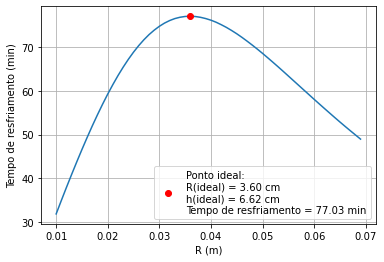

In [276]:
maior_tempo = max(lista_de_pontos3)
i_maior_t = lista_de_pontos3.index(maior_tempo)
h = vo / (pi * Rs[i_maior_t] * Rs[i_maior_t])
plt.plot(Rs, lista_de_pontos3)
plt.plot(Rs[i_maior_t], maior_tempo, 'ro', label=f'Ponto ideal:\nR(ideal) = {Rs[i_maior_t] * 100:.2f} cm \nh(ideal) = {h * 100:.2f} cm \nTempo de resfriamento = {maior_tempo:.2f} min')
plt.xlabel("R (m)")
plt.ylabel("Tempo de resfriamento (min)")
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [257]:
print(f'O tempo máximo de resfriamento é: {max(lista_de_pontos3)}')

O tempo máximo de resfriamento é: 77.03333333333333
